In [3]:
from pm4py.objects.log.importer.xes import importer as xes_importer
variant = xes_importer.Variants.ITERPARSE
parameters = {variant.value.Parameters.TIMESTAMP_SORT: True,variant.value.Parameters.TIMESTAMP_KEY : 'time:timestamp'}
log = xes_importer.apply('Road_Traffic_Fine_Management_Process-Copy1.xes', variant = variant,
                         parameters=parameters)

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

In [4]:
from pm4py.statistics.traces.generic.log import case_statistics
median_case_duration = case_statistics.get_median_caseduration(log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})

C:\Users\Sava\AppData\Local\Temp/ipykernel_9536/387085876.py:2: DeprecatedWarning: get_median_caseduration is deprecated as of 2.2.11 and will be removed in 3.0.0. please use get_median_case_duration instead
  median_case_duration = case_statistics.get_median_caseduration(log, parameters={


C:\Users\Sava\AppData\Local\Temp/ipykernel_9536/1310779844.py:4: DeprecatedWarning: get_median_caseduration is deprecated as of 2.2.11 and will be removed in 3.0.0. please use get_median_case_duration instead
  median_case_duration = case_statistics.get_median_caseduration(log, parameters={


The median case duration is 198 days


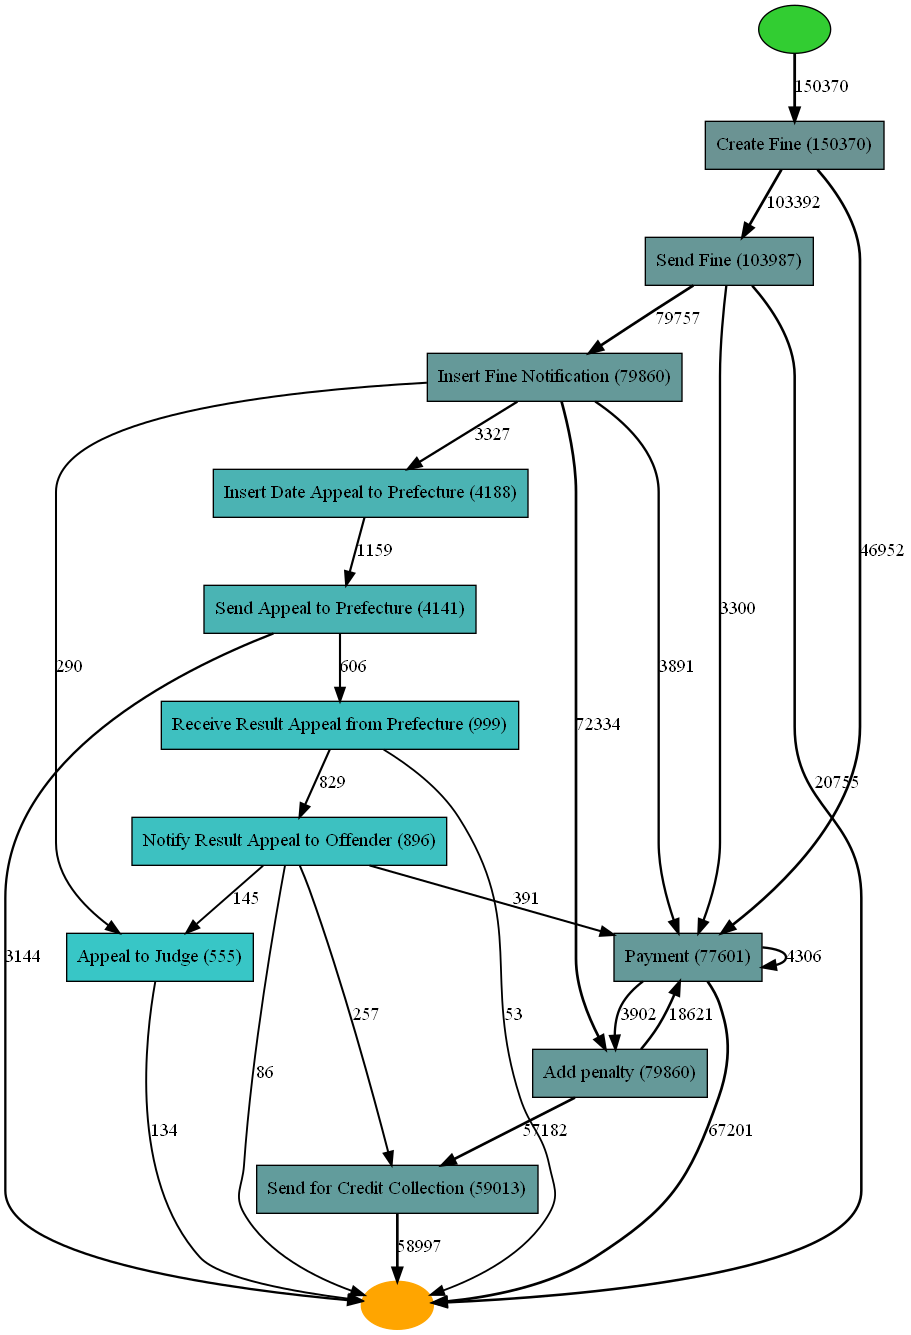

In [5]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.statistics.traces.generic.log import case_statistics
median_case_duration = case_statistics.get_median_caseduration(log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})
print('The median case duration is {} days'.format(round(median_case_duration/3600/24)))
heu_net = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)


# Pre- processing

### Transaction table

In [6]:
import pm4py
strings = []
numerics = []
attributes_list = pm4py.get_event_attributes(log)
for a in attributes_list:
    attribute_values = pm4py.get_event_attribute_values(log, (a))
    type_v = type(list(attribute_values.keys())[0])
    sum_attr_values = sum(attribute_values.values())
    if type_v == str :
        strings.append(a)
    elif type_v == float or type_v == int:
        if sum_attr_values >= len(log):
            numerics.append(a)
#for attr in numerics:
    #attr_values = pm4py.get_event_attribute_values(log,attr)
    #if sum(attr_values.values()) < len(log):
        #numerics.remove(attr)
print(strings)
print(numerics)

['vehicleClass', 'notificationType', 'lastSent', 'org:resource', 'concept:name', 'dismissal']
['amount', 'totalPaymentAmount', 'points', 'article']


In [7]:
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features

data, feature_names = log_to_features.apply(log, parameters={"str_ev_attr": strings, 
                    "str_tr_attr": [], "num_ev_attr": numerics, "num_tr_attr": [], "str_evsucc_attr": []})
print(len(feature_names))

200


In [8]:
import pandas as pd
df = pd.DataFrame(data, columns=feature_names)
df

,event:vehicleClass@A,event:vehicleClass@C,event:vehicleClass@M,event:vehicleClass@R,event:notificationType@C,event:notificationType@P,event:notificationType@UNDEFINED,event:lastSent@C,event:lastSent@N,event:lastSent@P,...,event:dismissal@Q,event:dismissal@R,event:dismissal@T,event:dismissal@U,event:dismissal@V,event:dismissal@Z,event:amount,event:totalPaymentAmount,event:points,event:article
0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,125.19,0.00,0,158
1,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,125.19,0.00,0,158
2,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,62.59,42.71,0,158
3,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,62.59,0.00,0,158
4,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,62.59,0.00,0,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150365,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,41.00,41.00,0,7
150366,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,41.00,41.00,0,7
150367,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,41.00,41.00,0,7
150368,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,41.00,41.00,0,7


#### Drop missing string values

In [10]:
columns = []
import re
r = '[\w\d\s:]+@UNDEFINED'
for x in df.columns:
    if re.search(r,x):
        columns.append(x)

print(columns)

['event:notificationType@UNDEFINED', 'event:lastSent@UNDEFINED']


In [11]:
df.drop(columns = columns, inplace = True)

#### Identify numeric columns and one-hot encode them

In [12]:
for col in df.columns:
    for val in df[col].unique():
        if val != 1 and val != 0:
            print(col)
            break

event:amount
event:totalPaymentAmount
event:points
event:article


In [13]:
amount = pd.cut(df['event:amount'], 
                            bins=[0,0.00001,50,100,999,100000], 
                            labels=['Zero','Low', 'Medium', 'High', 'Really High'],
                            include_lowest = True)
totalpayment=pd.cut(df['event:totalPaymentAmount'], 
                            bins=[0,0.00001,50,100,999,100000], 
                            labels=['Zero','Low', 'Medium', 'High', 'Really High'],
                            include_lowest = True)
article = pd.cut(df['event:article'], 
                            bins=[0,0.00001,50,100,999,100000], 
                            labels=['Zero','Low', 'Medium', 'High', 'Really High'],
                            include_lowest = True)
points = pd.cut(df['event:points'],
                       bins = [0.0,0.00001,50,100,999,100000],
                       labels = ['Zero','Low', 'Medium', 'High', 'Really High'],
                        include_lowest = True)

In [14]:
df.drop(columns = ['event:article','event:totalPaymentAmount','event:points','event:amount'], inplace = True)

In [15]:
df['event:points'] = points
df['event:article'] =article
df['event:totalPaymentAmount'] = totalpayment
df['event:amount'] = amount

In [16]:
df = pd.get_dummies(data = df, columns = {'event:article','event:points','event:totalPaymentAmount','event:amount'},prefix_sep='@')

In [17]:
df.shape

(150370, 214)

#### Drop activity names

In [18]:
columns = []
import re
r = 'event:concept:name@[\w\d\s:]+'
for x in df.columns:
    if re.search(r,x):
        columns.append(x)

print(columns)

['event:concept:name@Add penalty', 'event:concept:name@Appeal to Judge', 'event:concept:name@Create Fine', 'event:concept:name@Insert Date Appeal to Prefecture', 'event:concept:name@Insert Fine Notification', 'event:concept:name@Notify Result Appeal to Offender', 'event:concept:name@Payment', 'event:concept:name@Receive Result Appeal from Prefecture', 'event:concept:name@Send Appeal to Prefecture', 'event:concept:name@Send Fine', 'event:concept:name@Send for Credit Collection']


In [19]:
df.drop(columns = columns, inplace = True)

#### Drop values with support higher than 0.95

In [20]:
df.mean().sort_values(ascending = False).head(20)

event:dismissal@NIL                0.996648
event:points@Zero                  0.976405
event:vehicleClass@A               0.975673
event:article@High                 0.703837
event:totalPaymentAmount@Zero      0.536384
event:notificationType@P           0.530199
event:amount@Low                   0.482151
event:amount@Medium                0.411438
event:totalPaymentAmount@Low       0.343280
event:lastSent@P                   0.309078
event:article@Low                  0.291454
event:lastSent@N                   0.201589
event:amount@High                  0.104043
event:totalPaymentAmount@Medium    0.099029
event:org:resource@538             0.057245
event:org:resource@550             0.052770
event:org:resource@541             0.048919
event:org:resource@537             0.046093
event:org:resource@559             0.042755
event:org:resource@557             0.036151
dtype: float64

In [21]:
for x in df.columns:
    if df[x].mean() > 0.95:
        df.drop(columns = [x], inplace = True)

### Mine frequent item sets

In [22]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(df, min_support = 0.01,max_len = 3, use_colnames = True)

In [23]:
frequent_itemsets.sort_values(by = 'support',ascending = False)

,support,itemsets
27,0.703837,(event:article@High)
32,0.536384,(event:totalPaymentAmount@Zero)
1,0.530199,(event:notificationType@P)
29,0.482151,(event:amount@Low)
30,0.411438,(event:amount@Medium)
...,...,...
144,0.010062,"(event:amount@Medium, event:org:resource@558)"
234,0.010049,"(event:notificationType@P, event:amount@Medium..."
233,0.010042,"(event:notificationType@P, event:article@High,..."
291,0.010042,"(event:lastSent@P, event:amount@Medium, event:..."


### Mine association rules

In [24]:
from mlxtend.frequent_patterns import association_rules
rules_mlxtend1 = association_rules(frequent_itemsets, metric="leverage", min_threshold=0.05)

In [25]:
pd.set_option('display.max_colwidth', None)

In [26]:
rules_mlxtend1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(event:notificationType@P),(event:lastSent@N),0.530199,0.201589,0.201137,0.379362,1.881854,0.094255,1.286435
1,(event:lastSent@N),(event:notificationType@P),0.201589,0.530199,0.201137,0.997757,1.881854,0.094255,209.427683
2,(event:lastSent@P),(event:notificationType@P),0.309078,0.530199,0.309078,1.000000,1.886085,0.145205,inf
3,(event:notificationType@P),(event:lastSent@P),0.530199,0.309078,0.309078,0.582947,1.886085,0.145205,1.656676
4,(event:notificationType@P),(event:amount@Medium),0.530199,0.411438,0.375906,0.708991,1.723200,0.157762,2.022484
...,...,...,...,...,...,...,...,...,...
83,(event:totalPaymentAmount@Low),"(event:amount@Low, event:article@High)",0.343280,0.288841,0.202314,0.589357,2.040420,0.103161,1.731817
84,"(event:totalPaymentAmount@Zero, event:article@High)",(event:amount@Medium),0.384059,0.411438,0.224207,0.583782,1.418881,0.066190,1.414071
85,"(event:article@High, event:amount@Medium)",(event:totalPaymentAmount@Zero),0.318188,0.536384,0.224207,0.704636,1.313679,0.053536,1.569643
86,(event:totalPaymentAmount@Zero),"(event:article@High, event:amount@Medium)",0.536384,0.318188,0.224207,0.417997,1.313679,0.053536,1.171492


In [27]:
rules_mlxtend1.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,0.371408,0.371408,0.216417,0.629698,1.718850,0.086355,inf
std,0.123588,0.123588,0.066254,0.206570,0.217958,0.027516,NaN
min,0.115894,0.115894,0.107774,0.223528,1.313679,0.051896,1.138619
25%,0.291508,0.291508,0.163982,0.423280,1.519111,0.065736,1.332628
50%,0.378274,0.378274,0.220197,0.653182,1.780459,0.080946,1.649456
75%,0.494163,0.494163,0.278719,0.745219,1.883210,0.103359,2.172151
max,0.536384,0.536384,0.399714,1.000000,2.040420,0.157762,inf


### Most interesting association rules

In [28]:
rules_mlxtend = rules_mlxtend1[(rules_mlxtend1['lift'] > 1.780459) & (rules_mlxtend1['confidence'] >0.653182)
                             & (rules_mlxtend1['conviction'] >1.649456) & (rules_mlxtend1['leverage'] >0.080946)]

In [29]:
rules_mlxtend.reset_index(inplace = True, drop = True)

In [30]:
rules_mlxtend

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(event:lastSent@N),(event:notificationType@P),0.201589,0.530199,0.201137,0.997757,1.881854,0.094255,209.427683
1,(event:lastSent@P),(event:notificationType@P),0.309078,0.530199,0.309078,1.000000,1.886085,0.145205,inf
2,(event:totalPaymentAmount@Low),(event:amount@Low),0.343280,0.482151,0.310095,0.903330,1.873543,0.144582,5.356886
3,(event:lastSent@N),"(event:notificationType@P, event:totalPaymentAmount@Zero)",0.201589,0.399714,0.163982,0.813446,2.035071,0.083404,3.217766
4,"(event:lastSent@P, event:article@High)",(event:notificationType@P),0.219126,0.530199,0.219126,1.000000,1.886085,0.102946,inf
5,(event:lastSent@P),"(event:notificationType@P, event:article@High)",0.309078,0.378274,0.219126,0.708968,1.874220,0.102210,2.136282
6,"(event:lastSent@P, event:amount@Medium)",(event:notificationType@P),0.225071,0.530199,0.225071,1.000000,1.886085,0.105739,inf
7,(event:lastSent@P),"(event:notificationType@P, event:amount@Medium)",0.309078,0.375906,0.225071,0.728204,1.937196,0.108887,2.296183
8,"(event:lastSent@P, event:totalPaymentAmount@Zero)",(event:notificationType@P),0.221268,0.530199,0.221268,1.000000,1.886085,0.103952,inf
9,(event:lastSent@P),"(event:notificationType@P, event:totalPaymentAmount@Zero)",0.309078,0.399714,0.221268,0.715896,1.791021,0.097725,2.112912


### Extract the rules

In [31]:
def antecedents_list(dataframe):
    ass_rules_ant = []
    for i in range(len(dataframe)):
        if len(dataframe.loc[i,'antecedents']) == 1:
            ant = re.findall(r"frozenset\({'(event:\S+@[\w\s]+)",str(dataframe.loc[i,'antecedents']))
            ass_rules_ant.append(ant)
        elif len(dataframe.loc[i,'antecedents']) == 2:
            antecedents = str(dataframe.loc[i,'antecedents']).split(',')
        #print(antecedents)
            ant = [re.sub(r"frozenset\({'(event:\S+@[\w\s]+)'",r"\1",antecedents[0]), (re.sub(r"'(event:\S+@[\w\s]+)'}\)", r"\1", antecedents[1])).strip()]
            ass_rules_ant.append(ant)
        else:
            antecedents = str(dataframe.loc[i,'antecedents']).split(',')
            ant = [re.sub(r"frozenset\({'(event:\S+@[\w\s]+)'",r"\1",antecedents[0]), (re.sub(r"'(event:\S+@[\w\s]+)'}\)", r"\1", antecedents[1])).strip(), (re.sub(r"'(event:\S+@[\w\s]+)'}\)", r"\1", antecedents[2])).strip()]
            ass_rules_ant.append(ant)
        

    return ass_rules_ant

In [32]:
len(antecedents_list(rules_mlxtend))

15

In [33]:
def consequents_list(dataframe):
    ass_rules_cons = []
    for i in range(len(dataframe)):
        if len(dataframe.loc[i,'consequents']) == 1:
            cons = re.findall(r"frozenset\({'(event:\S+@[\w\s]+)",str(dataframe.loc[i,'consequents']))
            ass_rules_cons.append(cons)
        elif len(dataframe.loc[i,'consequents']) == 2:
            consequents = str(dataframe.loc[i,'consequents']).split(',')
            cons = [re.sub(r"frozenset\({'(event:\S+@[\w\s]+)'",r"\1",consequents[0]), (re.sub(r"'(event:\S+@[\w\s]+)'}\)", r"\1", consequents[1])).strip()]
            ass_rules_cons.append(cons)
        else:
            consequents = str(dataframe.loc[i,'consequents']).split(',')
            cons = [re.sub(r"frozenset\({'(event:\S+@[\w\s]+)'",r"\1",consequents[0]), (re.sub(r"'(event:\S+@[\w\s]+)'}\)", r"\1", consequents[1])).strip(), (re.sub(r"'(event:\S+@[\w\s]+)'}\)", r"\1", consequents[2])).strip()]
            ass_rules_cons.append(cons)
        
        
    return ass_rules_cons

In [34]:
len(consequents_list(rules_mlxtend))

15

In [35]:
ass_rules = zip(antecedents_list(rules_mlxtend),consequents_list(rules_mlxtend))
ass_rules_better = []
ass_rules_even_better = []
list_ass_rules = list(ass_rules)
#print(list_ass_rules)
for x in list_ass_rules:
    ass_rules_better.append([v for lst in x for v in lst])
#print(ass_rules_better)
#for v in ass_rules_better:
for x in ass_rules_better:
    ass_rules_even_better.append(tuple(sorted(x)))
ass_rules_even_better = list(set(ass_rules_even_better))
print(len(ass_rules_even_better))

10


#### Define some functions

In [36]:
from pm4py.util import constants
from pm4py.util.pandas_utils import check_is_dataframe, check_dataframe_columns
def filter_attribute_values(log, attribute, values, how="cases", positive=True):
    
    if check_is_dataframe(log):
        check_dataframe_columns(log)
        from pm4py.algo.filtering.pandas.attributes import attributes_filter
        if how == "events":
            return attributes_filter.apply_events(log, values,
                                                  parameters={constants.PARAMETER_CONSTANT_ATTRIBUTE_KEY: attribute,
                                                              attributes_filter.Parameters.POSITIVE: positive})
        elif how == "cases":
            return attributes_filter.apply(log, values, parameters={
                constants.PARAMETER_CONSTANT_ATTRIBUTE_KEY: attribute, attributes_filter.Parameters.POSITIVE: positive})
    else:
        from pm4py.algo.filtering.log.attributes import attributes_filter
        if how == "events":
            return attributes_filter.apply_events(log, values,
                                                  parameters={constants.PARAMETER_CONSTANT_ATTRIBUTE_KEY: attribute,
                                                              attributes_filter.Parameters.POSITIVE: positive})
        else:
            return attributes_filter.apply(log, values, parameters={
                constants.PARAMETER_CONSTANT_ATTRIBUTE_KEY: attribute, attributes_filter.Parameters.POSITIVE: positive})



import pm4py
def filter_numerics(event_attribute,value,event_log = log):
    zero_values = []
    low_values = []
    medium_values = []
    high_values = []
    really_high_values = []
    attribute_values = pm4py.get_event_attribute_values(log, (event_attribute))
    #print(attribute_values)
    #totalpayment=pd.cut(df['event:totalPaymentAmount'], 
                           # bins=[0,0.00001,50,100,999,100000], 
                          # labels=['Zero','Low', 'Medium', 'High', 'Really High'],
    for k in attribute_values.keys():
        if k > 999:
            really_high_values.append(k)
        elif k > 100 and k<= 999:
            high_values.append(k)
        elif k > 50 and k <= 100:
            medium_values.append(k)
        elif k > 0.00001 and k <= 50:
            low_values.append(k)
        else:
            zero_values.append(k)
    if value == 'Really High':
        filtered_log_cases = filter_attribute_values(event_log, attribute = event_attribute,
                                                 values = really_high_values, how="cases", positive=True )
    elif value == 'High':
        filtered_log_cases_1 = filter_attribute_values(event_log, attribute = event_attribute, 
                                                     values = really_high_values, how="cases", positive=False )

        filtered_log_cases = filter_attribute_values(filtered_log_cases_1, attribute = event_attribute, 
                                                     values = high_values, how="cases", positive=True )
    elif value == 'Medium':
        filtered_log_cases_1 = filter_attribute_values(event_log, attribute = event_attribute, 
                                                     values = really_high_values + high_values, how="cases", positive=False )

        filtered_log_cases = filter_attribute_values(filtered_log_cases_1, attribute = event_attribute, 
                                                     values = medium_values, how="cases", positive=True )
    elif value == 'Low':
        filtered_log_cases_1 = filter_attribute_values(event_log, attribute = event_attribute, 
                                                     values = really_high_values + high_values + medium_values, how="cases", positive=False )

        filtered_log_cases = filter_attribute_values(filtered_log_cases_1, attribute = event_attribute, 
                                                     values = low_values, how="cases", positive=True )
    else:
        filtered_log_cases = filter_attribute_values(event_log, attribute = event_attribute, 
                                                     values = really_high_values + high_values + medium_values + low_values, how="cases", positive=False )
    return filtered_log_cases

In [37]:
ass_rules_even_better

[('event:amount@Medium', 'event:article@High', 'event:notificationType@P'),
 ('event:lastSent@N',
  'event:notificationType@P',
  'event:totalPaymentAmount@Zero'),
 ('event:amount@Medium', 'event:lastSent@P', 'event:notificationType@P'),
 ('event:amount@Low', 'event:article@High', 'event:totalPaymentAmount@Low'),
 ('event:amount@Medium',
  'event:notificationType@P',
  'event:totalPaymentAmount@Zero'),
 ('event:article@High', 'event:lastSent@P', 'event:notificationType@P'),
 ('event:lastSent@N', 'event:notificationType@P'),
 ('event:lastSent@P', 'event:notificationType@P'),
 ('event:amount@Low', 'event:totalPaymentAmount@Low'),
 ('event:lastSent@P',
  'event:notificationType@P',
  'event:totalPaymentAmount@Zero')]

In [43]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics


rule_n = []
full_rule = []
days = []
for e,x in enumerate(ass_rules_even_better):
    log1 = log
    for i in range(len(x)):
        #regex1 = re.findall(r"event:(\S+)@([\w\s]+)",rule[0])
        regex = [p for tpl in re.findall(r"event:(\S+)@([\w\s]+)",x[i]) for p in tpl]
        #print(regex)
        if regex[0] in ['amount','points','article','totalPaymentAmount']:
            tracefilter_log_pos_rule = filter_numerics(regex[0],regex[1],log1)
        else:
            tracefilter_log_pos_rule= attributes_filter.apply(log1, [regex[1]],
                parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: regex[0], attributes_filter.Parameters.POSITIVE: True})
        log1 = tracefilter_log_pos_rule
    print('RULE {}'.format(e))
    rule_n.append('RULE {}'.format(e))
    print(x)
    full_rule.append(x)
    #print(len(log1))
    median_case_duration = case_statistics.get_median_case_duration(log1, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
    })
    print('Median case duration is {} days '.format(round(median_case_duration/3600/24)))
    days.append(round(median_case_duration/3600/24))
    print('--------------')
    

C:\Users\Sava\AppData\Local\Temp/ipykernel_9536/1273641710.py:5: DeprecatedWarning: check_is_dataframe is deprecated as of 2.2.8 and will be removed in 3.0.0. use check_is_pandas_dataframe instead
  if check_is_dataframe(log):


RULE 0
('event:amount@Medium', 'event:article@High', 'event:notificationType@P')
Median case duration is 594 days 
--------------
RULE 1
('event:lastSent@N', 'event:notificationType@P', 'event:totalPaymentAmount@Zero')
Median case duration is 587 days 
--------------
RULE 2
('event:amount@Medium', 'event:lastSent@P', 'event:notificationType@P')
Median case duration is 612 days 
--------------
RULE 3
('event:amount@Low', 'event:article@High', 'event:totalPaymentAmount@Low')
Median case duration is 5 days 
--------------
RULE 4
('event:amount@Medium', 'event:notificationType@P', 'event:totalPaymentAmount@Zero')
Median case duration is 631 days 
--------------
RULE 5
('event:article@High', 'event:lastSent@P', 'event:notificationType@P')
Median case duration is 619 days 
--------------
RULE 6
('event:lastSent@N', 'event:notificationType@P')
Median case duration is 558 days 
--------------
RULE 7
('event:lastSent@P', 'event:notificationType@P')
Median case duration is 617 days 
------------

In [44]:
print(rule_n)
print(full_rule)
print(days)

['RULE 0', 'RULE 1', 'RULE 2', 'RULE 3', 'RULE 4', 'RULE 5', 'RULE 6', 'RULE 7', 'RULE 8', 'RULE 9']
[('event:amount@Medium', 'event:article@High', 'event:notificationType@P'), ('event:lastSent@N', 'event:notificationType@P', 'event:totalPaymentAmount@Zero'), ('event:amount@Medium', 'event:lastSent@P', 'event:notificationType@P'), ('event:amount@Low', 'event:article@High', 'event:totalPaymentAmount@Low'), ('event:amount@Medium', 'event:notificationType@P', 'event:totalPaymentAmount@Zero'), ('event:article@High', 'event:lastSent@P', 'event:notificationType@P'), ('event:lastSent@N', 'event:notificationType@P'), ('event:lastSent@P', 'event:notificationType@P'), ('event:amount@Low', 'event:totalPaymentAmount@Low'), ('event:lastSent@P', 'event:notificationType@P', 'event:totalPaymentAmount@Zero')]
[594, 587, 612, 5, 631, 619, 558, 617, 5, 672]


In [45]:
df_days = pd.DataFrame(data = list(zip(full_rule, days)), index = rule_n, columns = ['Associaton Rule', 'Days'])

In [46]:
df_days

,Associaton Rule,Days
RULE 0,"(event:amount@Medium, event:article@High, event:notificationType@P)",594
RULE 1,"(event:lastSent@N, event:notificationType@P, event:totalPaymentAmount@Zero)",587
RULE 2,"(event:amount@Medium, event:lastSent@P, event:notificationType@P)",612
RULE 3,"(event:amount@Low, event:article@High, event:totalPaymentAmount@Low)",5
RULE 4,"(event:amount@Medium, event:notificationType@P, event:totalPaymentAmount@Zero)",631
RULE 5,"(event:article@High, event:lastSent@P, event:notificationType@P)",619
RULE 6,"(event:lastSent@N, event:notificationType@P)",558
RULE 7,"(event:lastSent@P, event:notificationType@P)",617
RULE 8,"(event:amount@Low, event:totalPaymentAmount@Low)",5
RULE 9,"(event:lastSent@P, event:notificationType@P, event:totalPaymentAmount@Zero)",672


# Heuristic Miner

### Filter for ('event:lastSent@N', 'event:notificationType@P')

('event:lastSent@N', 'event:notificationType@P')
30245
The median case duration is 558 days


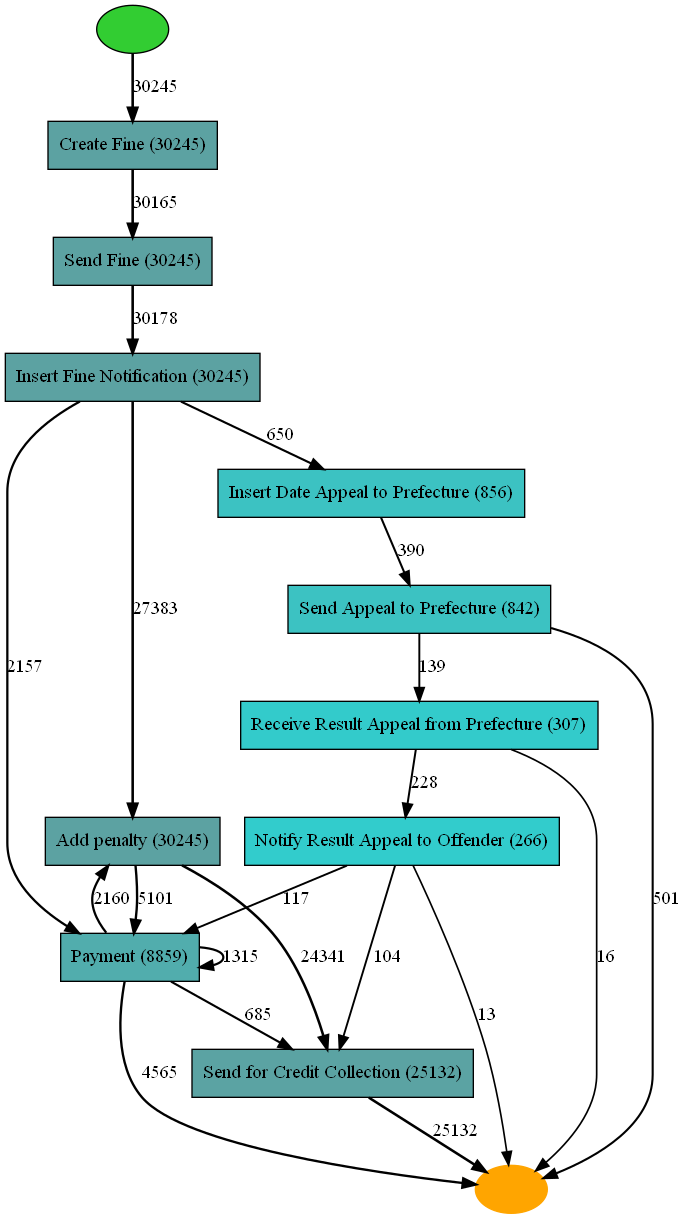

--------------


In [39]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics


log1 = log
for i in range(len(ass_rules_even_better[6])):
    regex = [p for tpl in re.findall(r"event:(\S+)@([\w\s]+)",ass_rules_even_better[6][i]) for p in tpl]
    if regex[0] in ['amount','points','article','totalPaymentAmount']:
        tracefilter_log_pos_rule = filter_numerics(regex[0],regex[1],log1)
    else:
        tracefilter_log_pos_rule= attributes_filter.apply(log1, [regex[1]],
            parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: regex[0], attributes_filter.Parameters.POSITIVE: True})
    log1 = tracefilter_log_pos_rule
print(ass_rules_even_better[6])
print(len(log1))
median_case_duration = case_statistics.get_median_case_duration(log1, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})
print('The median case duration is {} days'.format(round(median_case_duration/3600/24)))
#var_counts = case_statistics.get_variant_statistics(log1)
#for pr_var in var_counts[:5]:
   # print(pr_var)
heu_net = heuristics_miner.apply_heu(log1, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)
print('--------------')

### Filter for ('event:lastSent@P', 'event:notificationType@P')

('event:lastSent@P', 'event:notificationType@P')
46476
The median case duration is 617 days


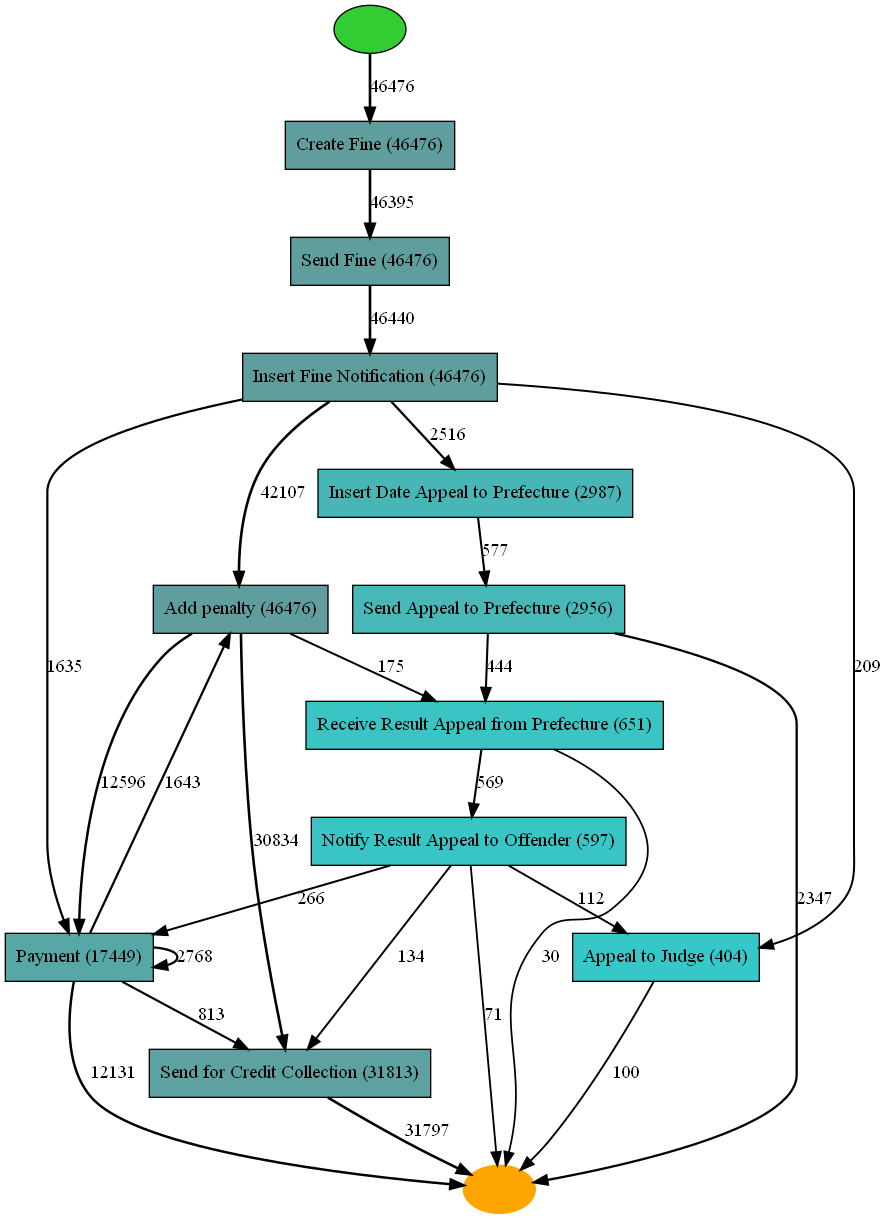

--------------


In [40]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics


log1 = log
for i in range(len(ass_rules_even_better[7])):
    regex = [p for tpl in re.findall(r"event:(\S+)@([\w\s]+)",ass_rules_even_better[7][i]) for p in tpl]
    if regex[0] in ['amount','points','article','totalPaymentAmount']:
        tracefilter_log_pos_rule = filter_numerics(regex[0],regex[1],log1)
    else:
        tracefilter_log_pos_rule= attributes_filter.apply(log1, [regex[1]],
            parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: regex[0], attributes_filter.Parameters.POSITIVE: True})
    log1 = tracefilter_log_pos_rule
print(ass_rules_even_better[7])
print(len(log1))
median_case_duration = case_statistics.get_median_case_duration(log1, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})
print('The median case duration is {} days'.format(round(median_case_duration/3600/24)))
#var_counts = case_statistics.get_variant_statistics(log1)
#for pr_var in var_counts[:5]:
   # print(pr_var)
heu_net = heuristics_miner.apply_heu(log1, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)
print('--------------')

### Filter for ('event:amount@Low', 'event:totalPaymentAmount@Low')

C:\Users\Sava\AppData\Local\Temp/ipykernel_9536/1273641710.py:5: DeprecatedWarning: check_is_dataframe is deprecated as of 2.2.8 and will be removed in 3.0.0. use check_is_pandas_dataframe instead
  if check_is_dataframe(log):


('event:amount@Low', 'event:totalPaymentAmount@Low')
46629
The median case duration is 5 days


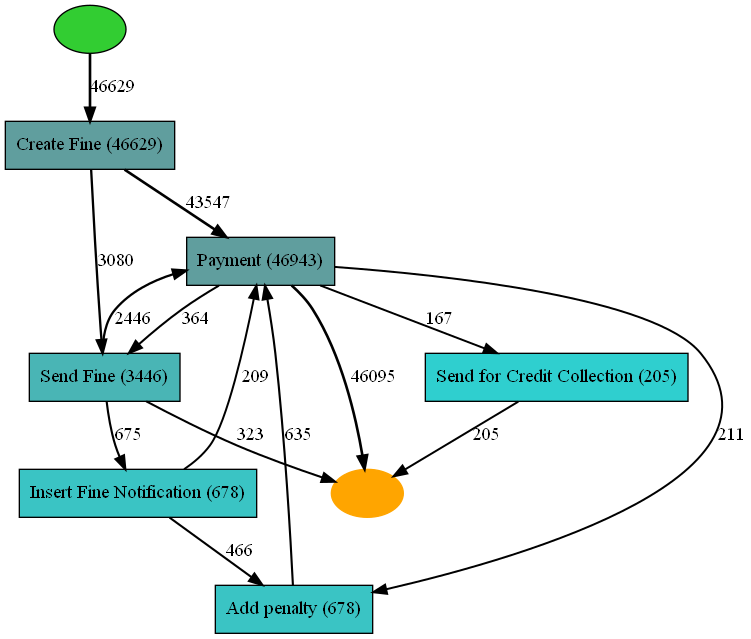

--------------


In [41]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics


log1 = log
for i in range(len(ass_rules_even_better[8])):
    regex = [p for tpl in re.findall(r"event:(\S+)@([\w\s]+)",ass_rules_even_better[8][i]) for p in tpl]
    if regex[0] in ['amount','points','article','totalPaymentAmount']:
        tracefilter_log_pos_rule = filter_numerics(regex[0],regex[1],log1)
    else:
        tracefilter_log_pos_rule= attributes_filter.apply(log1, [regex[1]],
            parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: regex[0], attributes_filter.Parameters.POSITIVE: True})
    log1 = tracefilter_log_pos_rule
print(ass_rules_even_better[8])
print(len(log1))
median_case_duration = case_statistics.get_median_case_duration(log1, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})
print('The median case duration is {} days'.format(round(median_case_duration/3600/24)))
#var_counts = case_statistics.get_variant_statistics(log1)
#for pr_var in var_counts[:5]:
   # print(pr_var)
heu_net = heuristics_miner.apply_heu(log1, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)
print('--------------')

### Filter for  ('event:lastSent@P','event:notificationType@P','event:totalPaymentAmount@Zero')

C:\Users\Sava\AppData\Local\Temp/ipykernel_9536/1273641710.py:5: DeprecatedWarning: check_is_dataframe is deprecated as of 2.2.8 and will be removed in 3.0.0. use check_is_pandas_dataframe instead
  if check_is_dataframe(log):


('event:lastSent@P', 'event:notificationType@P', 'event:totalPaymentAmount@Zero')
33272
The median case duration is 672 days


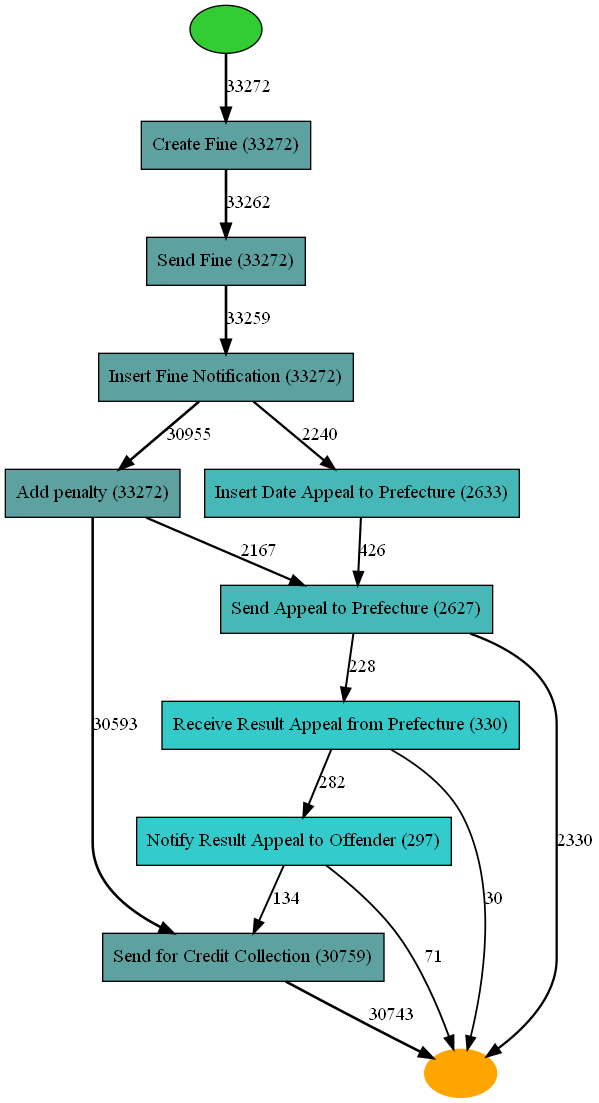

--------------


In [42]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics


log1 = log
for i in range(len(ass_rules_even_better[9])):
    regex = [p for tpl in re.findall(r"event:(\S+)@([\w\s]+)",ass_rules_even_better[9][i]) for p in tpl]
    if regex[0] in ['amount','points','article','totalPaymentAmount']:
        tracefilter_log_pos_rule = filter_numerics(regex[0],regex[1],log1)
    else:
        tracefilter_log_pos_rule= attributes_filter.apply(log1, [regex[1]],
            parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: regex[0], attributes_filter.Parameters.POSITIVE: True})
    log1 = tracefilter_log_pos_rule
print(ass_rules_even_better[9])
print(len(log1))
median_case_duration = case_statistics.get_median_case_duration(log1, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})
print('The median case duration is {} days'.format(round(median_case_duration/3600/24)))
#var_counts = case_statistics.get_variant_statistics(log1)
#for pr_var in var_counts[:5]:
   # print(pr_var)
heu_net = heuristics_miner.apply_heu(log1, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)
print('--------------')